<a href="https://colab.research.google.com/github/manavdewan02/Capstone-Project/blob/main/CT_Scan_Image_Classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [103]:
!nvidia-smi

Fri Nov 25 11:56:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |   9090MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Problem Statement

Dataset contains 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. The aim is to identify if a person is infected by SARS-CoV-2 through the analysis of his/her CT scans.

In [104]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import cv2

from tqdm import tqdm
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from skimage import io

from keras import Input
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# Data Mining

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
data_cov=pathlib.Path('/content/drive/MyDrive/Capstone/Input_data/COVID')
data_non_cov=pathlib.Path('/content/drive/MyDrive/Capstone/Input_data/non-COVID')

In [107]:
print("No. of images which are showing covid: ",len(list(data_cov.glob('*png')))) #.glob() is used to find files, here it is giving the number of .png files 
print("No. of images which are normal: ",len(list(data_non_cov.glob('*png'))))

No. of images which are showing covid:  1273
No. of images which are normal:  1242


In [108]:
#no. of covid and non covid images are approximately same

In [109]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/drive/MyDrive/Capstone/Input_data'
train_dir = os.path.join(data_dir)
#it is used to join more than one path together

In [110]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type']) #created a pandas dataframe, with new columns as disease id and disease type
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (828).png,0,COVID
1,COVID/Covid (840).png,0,COVID
2,COVID/Covid (732).png,0,COVID
3,COVID/Covid (735).png,0,COVID
4,COVID/Covid (847).png,0,COVID


In [111]:
train

,File,DiseaseID,Disease Type
0,COVID/Covid (828).png,0,COVID
1,COVID/Covid (840).png,0,COVID
2,COVID/Covid (732).png,0,COVID
3,COVID/Covid (735).png,0,COVID
4,COVID/Covid (847).png,0,COVID
...,...,...,...
2511,non-COVID/Non-Covid (809).png,1,non-COVID
2512,non-COVID/Non-Covid (711).png,1,non-COVID
2513,non-COVID/Non-Covid (74).png,1,non-COVID
2514,non-COVID/Non-Covid (717).png,1,non-COVID


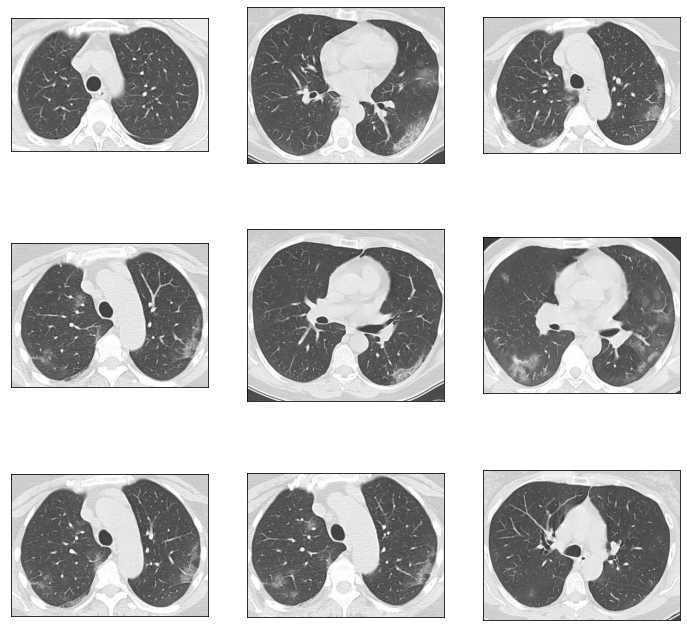

In [112]:
#displaying some of images of covid training data set
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
plot_defects('COVID', 3, 3)

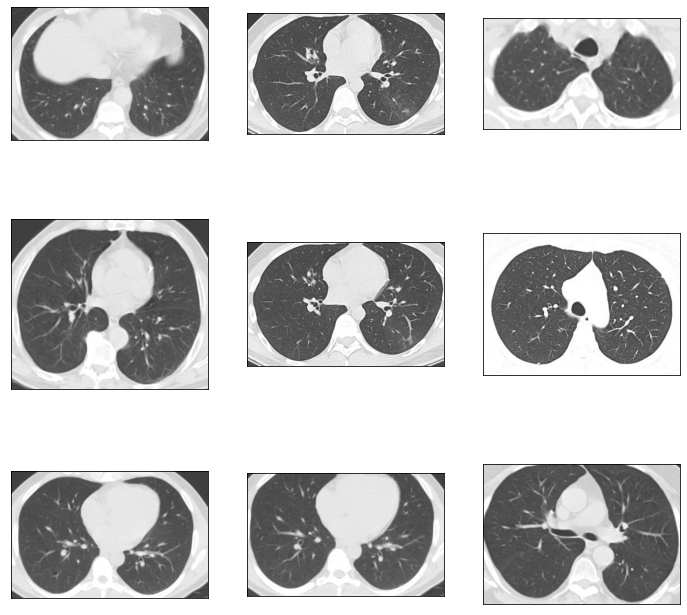

In [113]:
#displaying some of images of non-covid training data set
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
plot_defects('non-COVID', 3, 3)


In [114]:
#Resizing images
#The images are in different sizes so need to fix size

IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [115]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2516it [00:15, 164.40it/s]


(2516, 64, 64, 3)


In [116]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
Y_train.shape

(2516, 2)

# Splitting and Creating Model

In [117]:
Batch_Size=65
#splitting the data for training and validation
X_train,X_val,Y_train,Y_val=train_test_split(X_Train,Y_train,test_size=0.2,random_state=42)

In [118]:
X_train.shape

(2012, 64, 64, 3)

In [119]:
X_val.shape

(504, 64, 64, 3)

In [120]:
Y_train.shape

(2012, 2)

In [121]:
Y_val.shape

(504, 2)

In [122]:
Epochs=500
size=64

In [123]:
#Creating the model
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(size,size,3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [124]:
#Data Augmentation
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, #Degree range for rotations
                        width_shift_range=0.2, #horizontal shifts
                        height_shift_range=0.2, #vertical shifts
                        zoom_range=0.2, #Range for zoom
                        horizontal_flip=True, #flip inputs horizontally
                        vertical_flip=True) #flip inputs vertically

datagen.fit(X_train)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_6 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0   

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [125]:
#Early Stopping
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [126]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=Batch_Size),
               steps_per_epoch=X_train.shape[0] // Batch_Size,
               epochs=Epochs,
               verbose=1,
               callbacks=[annealer, checkpoint, early_stopping],
               validation_data=(X_val, Y_val))


Epoch 1/500
30/30 [==============================] - ETA: 0s - loss: 1.2358 - accuracy: 0.5280
Epoch 1: val_loss improved from inf to 1.46597, saving model to model.h5
30/30 [==============================] - 22s 262ms/step - loss: 1.2358 - accuracy: 0.5280 - val_loss: 1.4660 - val_accuracy: 0.4960 - lr: 0.0030
Epoch 2/500
30/30 [==============================] - ETA: 0s - loss: 1.0950 - accuracy: 0.5763
Epoch 2: val_loss improved from 1.46597 to 0.81098, saving model to model.h5
30/30 [==============================] - 5s 164ms/step - loss: 1.0950 - accuracy: 0.5763 - val_loss: 0.8110 - val_accuracy: 0.4960 - lr: 0.0030
Epoch 3/500
30/30 [==============================] - ETA: 0s - loss: 0.9148 - accuracy: 0.6323
Epoch 3: val_loss did not improve from 0.81098
30/30 [==============================] - 4s 117ms/step - loss: 0.9148 - accuracy: 0.6323 - val_loss: 1.8994 - val_accuracy: 0.5040 - lr: 0.0030
Epoch 4/500
30/30 [==============================] - ETA: 0s - loss: 0.7986 - accurac

#Model Prediction

In [127]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

16/16 [==============================] - 1s 21ms/step


1/1 [==============================] - 0s 25ms/step
[0.98376775 0.0162323 ]


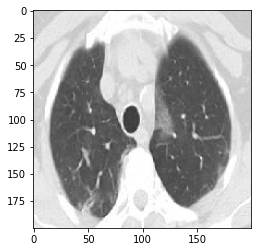

In [128]:
from skimage import io
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/drive/MyDrive/Capstone/Input_data/COVID/Covid (502).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/MyDrive/Capstone/Input_data/COVID/Covid (502).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)

#Multiple Performance Metrics

In [129]:
confusion_matrix(Y_true, Y_pred)


array([[231,  23],
       [ 21, 229]])

In [130]:
accuracy_score(Y_true, Y_pred)


0.9126984126984127

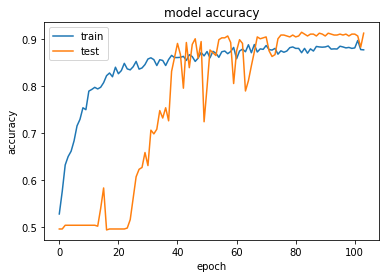

In [131]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

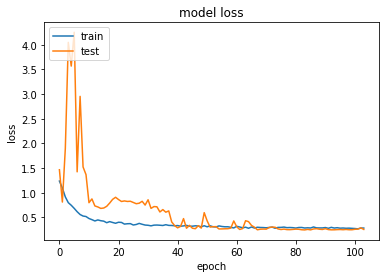

In [132]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [133]:
print(classification_report(Y_true, Y_pred, target_names=disease_class))

              precision    recall  f1-score   support

    Covid-19       0.92      0.91      0.91       254
Non Covid-19       0.91      0.92      0.91       250

    accuracy                           0.91       504
   macro avg       0.91      0.91      0.91       504
weighted avg       0.91      0.91      0.91       504

